# Epipolar Geometry

Let’s understand epipolar geometry and epipolar constraint.

## Learning Objective
In this chapter:

- We will see how to match features in one image with others.
- We will use the Brute-Force matcher and FLANN Matcher in OpenCV

### Packages

In [2]:
import os
import glob

import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Load the two images

We're going to use two photographs of the same object. The object is a book taken from two angles/pov. The aim is to calculate the two epilines:

- epilines in left image which contains projection of matching keypoints in right image
- epilines in right image which contains projection of matching keypoints in left image

In [3]:
img_left = cv2.imread('./data/left_real.jpg', cv2.IMREAD_GRAYSCALE) # query image
img_right = cv2.imread('./data/right_real.jpg', cv2.IMREAD_GRAYSCALE) # train image

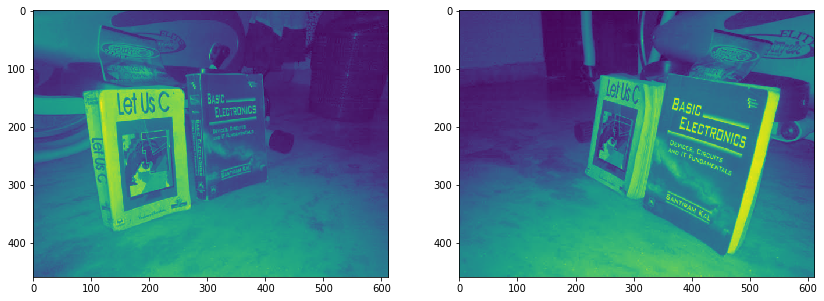

In [8]:
fig = plt.figure(figsize=(14, 14))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(img_left)
ax2.imshow(img_right)

### Drawing Helper
Before we begin, let's have a helper function that support drawing our keypoints and epilines on the image.
This will help aid our understanding by visualisation

In [22]:
# Helper to draw and plot matching keypoints
def draw_and_plot_matching_keypoints(img_left, kp_left, img_right, kp_right, 
                            matches, ratio_test=False, flags=cv2.DrawMatchesFlags_DEFAULT,
                            imshow_subtitle_prefix="Random shit:"):

    """ Draw matching keypoints given set of keypoints and descriptor of two images, and 
    a set of matching keypoints between two images' keypoints.

    Ideally the two images are photograph of the same object but taken at different pov.

    :param img_left (np image): the first input image 
    :param kp_left (np array): keypoints of the first image
    :param img_right (np image): the second input image
    :param kp_right (np array): keypoints of the second image
    :param matches (np array): matching points from descriptor matching of first and second image

    Note: Draw Function Flags:
        - DEFAULT = 0
        - DRAW_OVER_OUTIMG = 1
        - NOT_DRAW_SINGLE_POINTS = 2
        - DRAW_RICH_KEYPOINTS = 4
    """

    # draw keypoints on the left image
    img_left_kp = cv2.drawKeypoints(img_left, kp_left, None)

    # prepare plot figures
    fig_kp = plt.figure(figsize=(15,15))
    ax1 = fig_kp.add_subplot(1,2,1)
    ax2 = fig_kp.add_subplot(1,2,2)
    
    fig_match = plt.figure(figsize=(12,12))
    ax3 = fig_match.add_subplot(1,1,1)

    # draw keypoints on the right image
    img_right_kp = cv2.drawKeypoints(img_right, kp_right, None)

    # draw matching keypoints
    if ratio_test:
        img_match_kp = cv2.drawMatchesKnn(img_left, kp_left, img_right, kp_right, matches, 
                None, flags=2)
    else:
        img_match_kp = cv2.drawMatches(img_left, kp_left, img_right, kp_right, matches, 
                None, flags=flags) 
    
    # plot drawings of matching keypoints
    ax1.imshow(img_left_kp)
    ax1.set_title(imshow_subtitle_prefix + 'Image Left keypoints')
    ax2.imshow(img_right_kp)
    ax2.set_title(imshow_subtitle_prefix + 'Image Right keypoints')
    ax3.imshow(img_match_kp)
    ax3.set_title(imshow_subtitle_prefix + 'Matching keypoints')

## Basic of Brute Force Keypoints Matcher

Brute-Force matcher is simple. It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation. And the closest one is returned.

For BF matcher, first we have to create the BFMatcher object using **cv.BFMatcher()**. It takes two optional params. First one is normType. It specifies the distance measurement to be used. By default, it is cv.NORM_L2. It is good for SIFT, SURF etc (cv.NORM_L1 is also there).

For SIFT, SURF, etc. We usually use:

- cv2.NORM_L1
- cv2.NORM_L2 


For binary string based descriptors like ORB, BRIEF, BRISK etc. You should use:

- cv2.NORM_HAMMING which used Hamming distance as measurement. 
- cv.NORM_HAMMING2 If ORB is using WTA_K == 3 or 4, 

Second param is boolean variable, crossCheck which is false by default. If it is true, Matcher returns only those matches with value (i,j) such that i-th descriptor in set A has j-th descriptor in set B as the best match and vice-versa. That is, the two features in both sets should match each other. It provides consistent result, and is a good alternative to ratio test proposed by D.Lowe in SIFT paper.

Once it is created, two important methods are **BFMatcher.match()** and **BFMatcher.knnMatch()**. First one returns the best match. Second method returns k best matches where k is specified by the user. It may be useful when we need to do additional work on that.

Like we used **cv2.drawKeypoints()** to draw keypoints, **cv.drawMatches()** helps us to draw the matches. It stacks two images horizontally and draw lines from first image to second image showing best matches. There is also **cv2.drawMatchesKnn** which draws all the k best matches. If k=2, it will draw two match-lines for each keypoint. So we have to pass a mask if we want to selectively draw it.

Let's see one example for each of SURF and ORB (Both use different distance measurements).

### Brute Force Matching + ORB descriptor

Here, we will see a simple example on how to match features between two images. In this case, I have a queryImage and a trainImage. We will try to find the queryImage in trainImage using feature matching. ( The images are /samples/c/box.png and /samples/c/box_in_scene.png)

We are using ORB descriptors to match features. So let's start with loading images, finding descriptors etc.

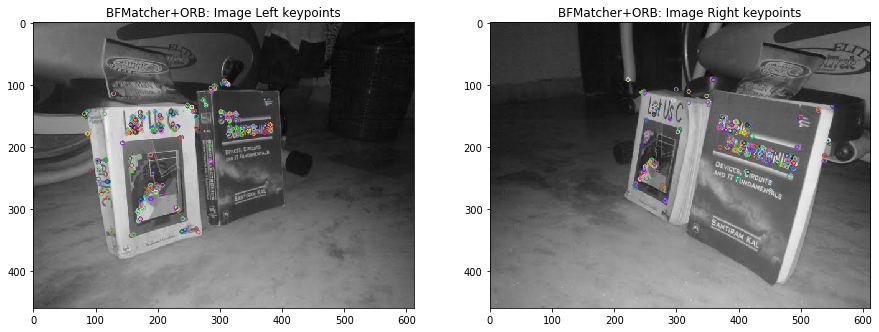

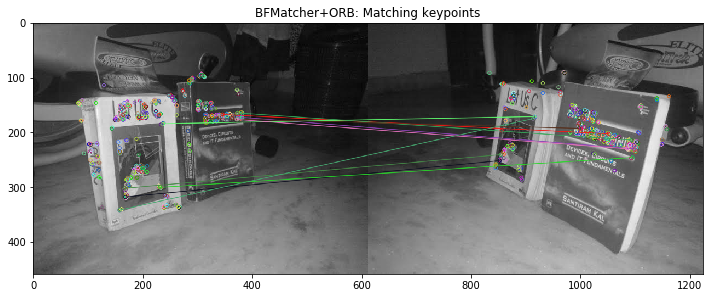

In [23]:
# -----------------------------------
# Brute Force Matcher + ORB
# -----------------------------------

orb = cv2.ORB_create()

# combine detector and descriptor, hence cv2::detectAndComputer
# calculating: keypoints, descriptor
kp_left, desc_left = orb.detectAndCompute(img_left, None)
kp_right, desc_right = orb.detectAndCompute(img_right, None)

# create descriptor matcher for matching keypoints in left and right image
bfmatcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# calculate match descriptor and sort it based on distance
# match_descr = bfmatcher.match(desc_left, desc_right)
matches = bfmatcher.match(desc_left, desc_right)
matches = sorted(matches, key = lambda x:x.distance)

draw_and_plot_matching_keypoints(img_left, kp_left, img_right, kp_right, 
                        matches[:10], flags=cv2.DrawMatchesFlags_DEFAULT,
                        imshow_prefix="BFMatcher+ORB: ")

### What is Matcher Object < DMatch obj.0x>

The result of matches = bf.match(des1,des2) line is a list of DMatch objects. This DMatch object has following attributes:

- **DMatch.distance** - Distance between descriptors. The lower, the better it is.
- **DMatch.trainIdx** - Index of the descriptor in train descriptors
- **DMatch.queryIdx** - Index of the descriptor in query descriptors
- **DMatch.imgIdx** - Index of the train image.

### Brute Force Matcher + SIFT descriptor

This time, we will use **BFMatcher.knnMatch( )** to get $k$ best matches. In this example, we will take $k=2$ so that we can apply ratio test explained by *D.Lowe* in his paper.

#### Default match vs KNN match

First one returns the best match. Second method returns $k$ best matches where $k$ is specified by the user. 
It may be useful when we need to do additional work on that.

In [24]:
# -----------------------------------
# Brute Force Matcher (KNN) + SIFT
# -----------------------------------

# sift is deprecated from opencv 3.4.2 onwards
sift = cv2.xfeatures2d.SIFT_create() # cv2.SIFT() for opencv 3.4.1 <

# find the keypoints and descriptors with SIFT
kp_left, desc_left = sift.detectAndCompute(img_left, None)
kp_right, desc_right = sift.detectAndCompute(img_right, None)

bfmatcher = cv2.BFMatcher()
matches = bfmatcher.knnMatch(desc_left, desc_right, k=2)

good_matches = []
points_left = []
points_right = []
thresh_ratio = 0.65

#### Warnings!

Take note not the types of `good_matches` to be passed to **cv2.drawMatchKnn**. It expects list of list of DMatch obj instead of just a list of DMatch object. The following is not a hacky stuff to bypass that.

Here we only use and draw one possible matching per keypoint, hence we only pass 1 element to the list. The inner list itself contains possible matching points to describe one keypoint in the image.

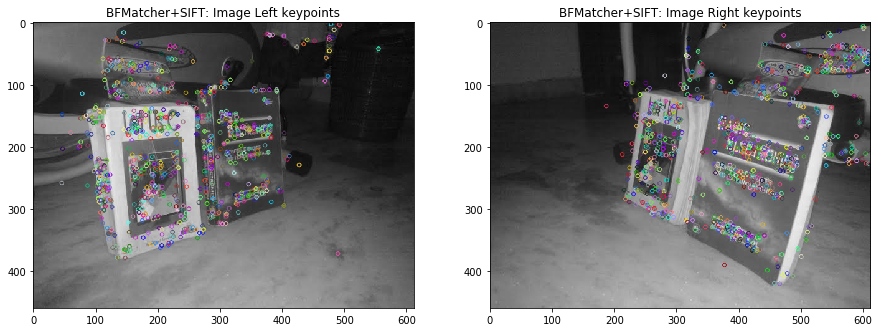

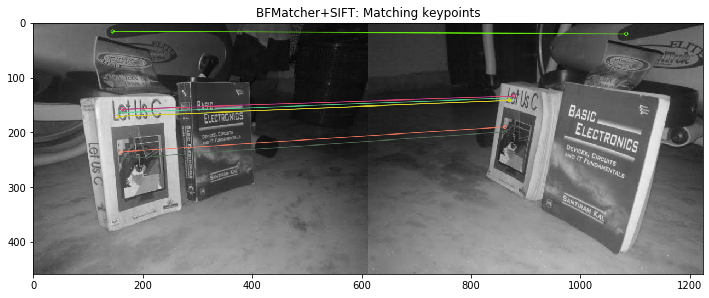

In [26]:
# using ratio tests as in Lowe's paper
for i, (m,n) in enumerate(matches):
    if m.distance < thresh_ratio* n.distance:
        #  Warning! In OpenCV 3.4.2 > drawMatchKnn expects list of list of DMatch obj
        #  In OpenCV 2.4.7 < it expects list of DMatch obj
        good_matches.append([m]) # or good_matches.append(m) in OpenCV 2.4.7
        points_right.append(kp_right[m.trainIdx].pt)
        points_left.append(kp_left[m.queryIdx].pt)

# draw matching keypoints
draw_and_plot_matching_keypoints(img_left, kp_left, img_right, kp_right, 
                    good_matches[:10], ratio_test=True, 
                    flags=cv2.DrawMatchesFlags_DEFAULT,
                    imshow_prefix="BFMatcher+SIFT: ")

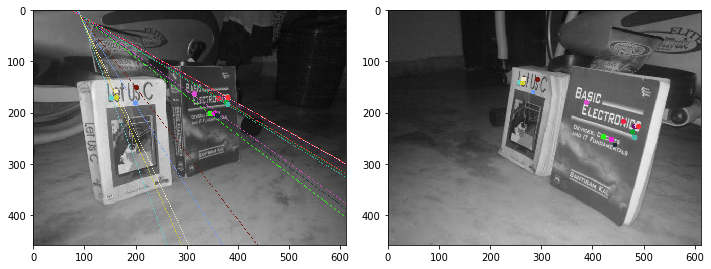

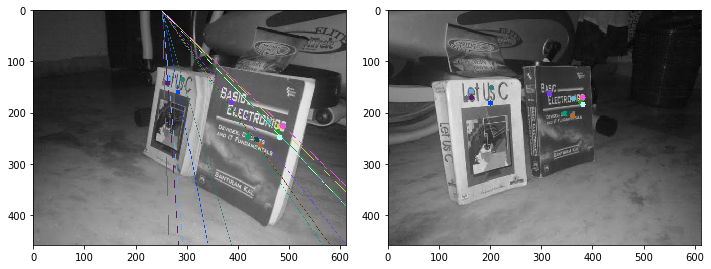

In [60]:
# -----------------------------------
# Flann Based Matcher + SIFT
# -----------------------------------

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary

# FLANN_INDEX_LSH = 6
# index_params= dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp_left, desc_left = sift.detectAndCompute(img_left, None)
kp_right, desc_right = sift.detectAndCompute(img_right, None)

# FLANN parameters
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc_left, desc_right, k=2)

good_matches = []
points_left = []
points_right = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.45 * n.distance:
        good_matches.append([m])
        points_right.append(kp_right[m.trainIdx].pt)
        points_left.append(kp_left[m.queryIdx].pt)

# now given best matches from both image,
# calculate the fundamental matrix and mask
points_left = np.int32(points_left)
points_right = np.int32(points_right)
F, mask = cv2.findFundamentalMat(points_left, points_right, cv2.FM_LMEDS)

# create inliers by using mask
inliers_left = points_left[mask.ravel() == 1]
inliers_right = points_right[mask.ravel() == 1]

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
epilines1 = cv2.computeCorrespondEpilines(points_right.reshape(-1,1,2), 2, F)
epilines1 = epilines1.reshape(-1,3)
img5, img6 = draw_epilines(img_left, img_right, epilines1,
                           points_left, points_right)

epilines2 = cv2.computeCorrespondEpilines(points_left.reshape(-1,1,2), 1, F)
epilines2 = epilines2.reshape(-1,3)
img3, img4 = draw_epilines(img_right, img_left, epilines2,
                           points_right, points_left)

In [58]:
# Helper to draw epilines on first image corresponding to
# matching points in second image
def draw_epilines(img1, img2, epilines, points1, points2):
    """
    :param img1 (np image): image which epilines is to be annotated.
    :param img2 (np image): image which points is found in the epilines of the 1st image
    :param epilines (np array): line on 1st image which contains projection points from 2nd image
    :param points1 (np array): matched keypoint on 1st image
    :param points2 (np array): matched keypoint on 2nd image
    """
    h,w = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(epilines, points1, points2):
        color = tuple(np.random.randint(0, 255, 3).tolist())

        x0,y0 = map(int, [0, -r[2] / r[1]])
        x1,y1 = map(int, [w, -(r[2] + r[0] *w) / r[1]])

        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)

    # prepare plot figures
    fig, axs = plt.subplots(1,2, figsize=(10, 20))
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    axs[0].imshow(img1)
    axs[1].imshow(img2)
        
    return img1, img2